In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("Data.csv")

In [2]:
data['Stroke(AIS,TIA,AHS)'] = 1
data.head()

,"Stroke(AIS,TIA,AHS)",Sex01,StrokeAge,gFGB,gF2,gF5,gF7VII,gF13,gITGA,gITGB,...,gADD1 1378 G>T,gAGT T704C,gAGT C521T,gAGTR1 A 1166C,gAGTR2 G1675A,gCYP11B2 C344T,gGNB3 825C>T,gNOS3 T786C,gNOS3 G894T,DisNeuro01
0,1,1,1.0,0,0,0,0.0,1.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0
1,1,1,3.0,0,0,0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0
2,1,0,5.0,0,0,0,0.0,1.0,1.0,2.0,...,1.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0
3,1,1,0.0,0,0,0,0.0,0.0,2.0,1.0,...,0.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,0
4,1,1,13.0,0,0,0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [3]:
X = data.ix[:, :-1]
Y = data.ix[:, -1]

X_dropped = data.dropna().ix[:, :-1]
Y_dropped = data.dropna().ix[:, -1]

попытаемся сделать еще выборку на данных, отбросив некоторые признаки

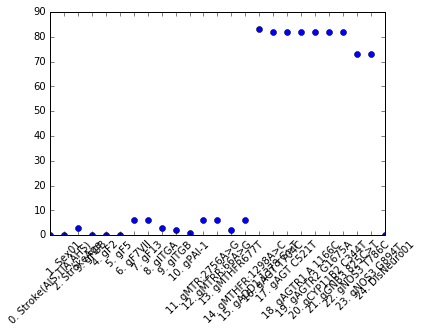

In [4]:
nulls = data.isnull().sum()
keys = nulls.keys()
values = nulls.values
words = [str(i)+". "+k.decode('utf-8').encode('ascii', 'ignore') for i, k in enumerate(nulls.keys())]

ind = np.arange(len(keys))
ax = plt.figure().add_subplot(111)
ax.set_xticks(ind)
ax.plot(values, 'o')
xtickNames = ax.set_xticklabels(words)
plt.setp(xtickNames, rotation=45, fontsize=10)

plt.show()

Мы видим, что в 9 столбцах из 24 имеется большое число пропусков. Удалим столбцы, а затем удалим из полученного фрейма строки, включающие в себя null'ы (их будет порядка десяти):

In [5]:
a = pd.DataFrame(values, keys)
indexes = a.loc[:].where(a < 50).dropna().index

In [7]:
data_chopped = data[indexes].dropna()
X_chopped = data_chopped.ix[:, :-1]
Y_chopped = data_chopped.ix[:, -1]
data_chopped.shape

(143, 16)

In [8]:
from sklearn.model_selection import train_test_split


Xd_train, Xd_test, yd_train, yd_test = train_test_split( 
    X_dropped, Y_dropped, test_size = 0.2, random_state=1, stratify=Y_dropped)

Xc_train, Xc_test, yc_train, yc_test = train_test_split( 
    X_chopped, Y_chopped, test_size = 0.2, random_state=1, stratify=Y_chopped)

In [9]:
from sklearn import tree

dt = tree.DecisionTreeClassifier()
dt = dt.fit(Xd_train, yd_train)
res = dt.predict(Xd_test)

In [10]:
dt2 = tree.DecisionTreeClassifier()
dt2 = dt2.fit(Xc_train, yc_train)
res2 = dt2.predict(Xc_test)

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [12]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(Xd_train, yd_train)
res = dt.predict(Xd_test)

print classification_report(yd_test, res)
print accuracy_score(yd_test, res)

             precision    recall  f1-score   support

          0       0.40      0.25      0.31         8
          1       0.40      0.57      0.47         7

avg / total       0.40      0.40      0.38        15

0.4


In [13]:
print classification_report(yc_test, res2)
print accuracy_score(yc_test, res2)

             precision    recall  f1-score   support

          0       0.67      0.67      0.67        15
          1       0.64      0.64      0.64        14

avg / total       0.66      0.66      0.66        29

0.655172413793


Очевидно, результат на данных с меньшим числом признаков лучше, чем на данных со всеми признаками.
Попробуем в случайный лес.

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
rf = rf.fit(Xd_train, yd_train)
res = rf.predict(Xd_test)

print classification_report(yd_test, res)
print accuracy_score(yd_test, res)

             precision    recall  f1-score   support

          0       0.50      0.75      0.60         8
          1       0.33      0.14      0.20         7

avg / total       0.42      0.47      0.41        15

0.466666666667


In [15]:
rf2 = RandomForestClassifier(random_state=1)
rf2 = rf2.fit(Xc_train, yc_train)
res2 = rf2.predict(Xc_test)

print classification_report(yc_test, res2)
print accuracy_score(yc_test, res2)

             precision    recall  f1-score   support

          0       0.64      0.47      0.54        15
          1       0.56      0.71      0.63        14

avg / total       0.60      0.59      0.58        29

0.586206896552


In [147]:
from sklearn.model_selection import GridSearchCV
from time import time

n_features=15

start=time()

param_grid = {
    "n_estimators": [5, 10, 18, 20],
    "criterion": ["gini", "entropy"],
    "max_features": [1, 3, 10, "sqrt"],
    "max_depth": [1, 3, 5, 10],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False],
             }
tuned_forest = GridSearchCV(RandomForestClassifier(), param_grid)
tuned_forest.fit(Xc_train, yc_train)

print "Taken time:", time()-start
print "Best params: ", tuned_forest.best_params_

Taken time: 729.778120041
Best params:  {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 5, 'min_samples_split': 10, 'criterion': 'entropy', 'max_features': 1, 'max_depth': 5}


NameError: name 'report' is not defined

In [22]:
from sklearn.model_selection import  StratifiedShuffleSplit, learning_curve
def learning_curve_model(X, Y, model, cv, train_sizes):
    """Функция строит кривую обучения"""
    plt.figure(figsize=(10, 10))
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")


    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt


In [20]:
rf_tuned = RandomForestClassifier(n_estimators=10, max_features=3,
                                  max_depth=3, criterion='entropy', 
                                  bootstrap=False, random_state=21)
rf_tuned.fit(Xc_train, yc_train)
res_tuned = rf_tuned.predict(Xc_test)
print classification_report(yc_test, res_tuned)
print accuracy_score(yc_test, res_tuned)

             precision    recall  f1-score   support

          0       0.67      0.67      0.67        15
          1       0.64      0.64      0.64        14

avg / total       0.66      0.66      0.66        29

0.655172413793


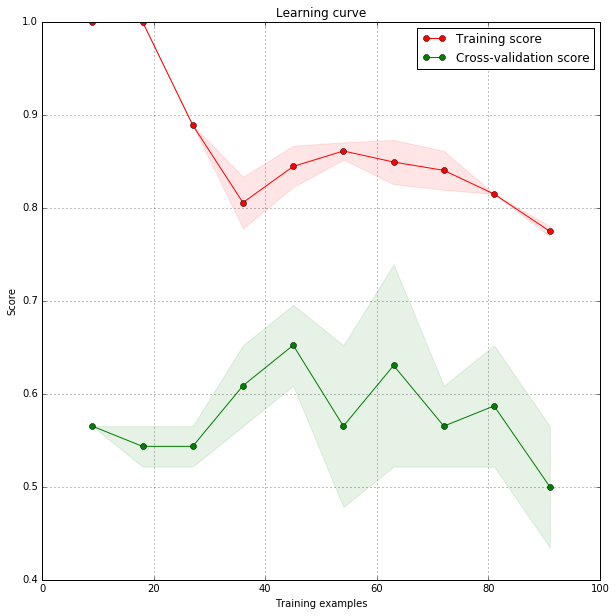

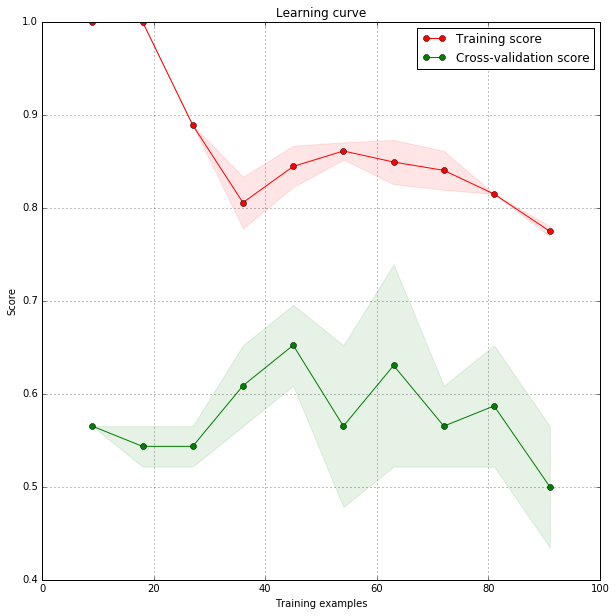

In [28]:
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
learning_curve_model(Xc_train, yc_train, rf_tuned, cv, np.linspace(0.1, 1.0, 10))
plt.show()

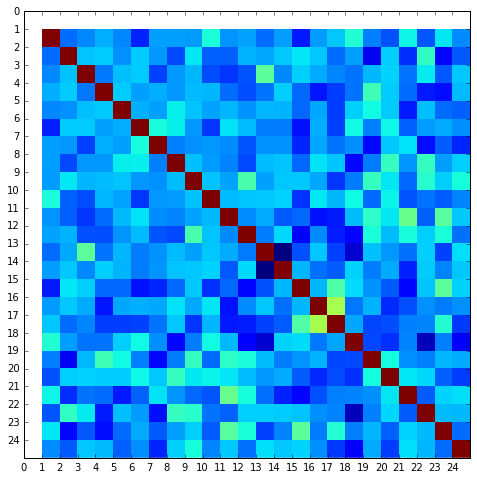

In [25]:
data.corr()
figure = plt.figure(figsize=(8, 8))
ax = figure.add_subplot(111)
ax.set_xticks(range(25))
ax.set_yticks(range(25))
ax.imshow(data.corr(), extent=[0,25,25,0], interpolation='none')
plt.show()

Посмотрим, как ведет себя модель RF при изменении параметров:

In [72]:
print data.corr().ix[17][16]

# plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
#                     cmap=plt.cm.Paired)

0.378641222831


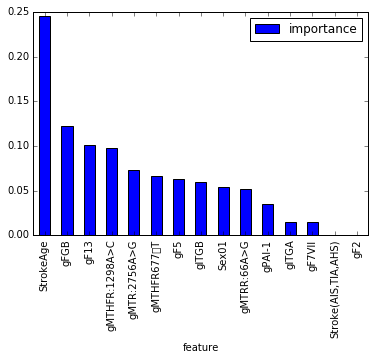

In [346]:
importances = pd.DataFrame({'feature':Xc_train.columns,'importance':dt2.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.show()

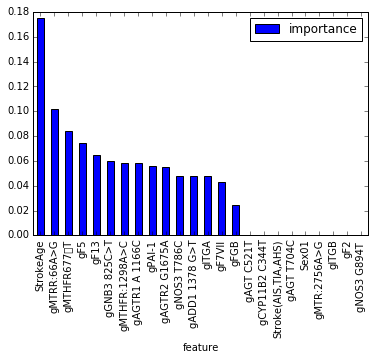

In [347]:
importances = pd.DataFrame({'feature':Xd_train.columns,'importance':dt.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.show()
# print importances

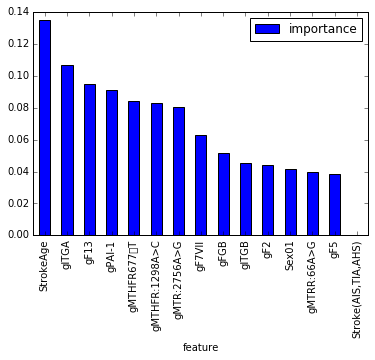

In [145]:
importances = pd.DataFrame({'feature':Xc_train.columns,'importance':rf_tuned.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.show()

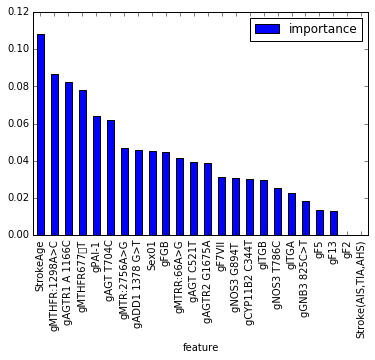

In [345]:
importances = pd.DataFrame({'feature':Xd_train.columns,'importance':rf.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.show()

Как видно, важность признаков в случайном лесе в среднем ниже, что обусловлено усреднением их значений при бэггинге.

In [94]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=8, shuffle=True)

for train_index, test_index in kf.split(X_chopped):
    print "TRAIN:", train_index, "TEST:", test_index

TRAIN: [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  26  27  28  30  31  32  33  35  36  37  39  40
  41  42  43  44  45  47  48  51  52  53  54  55  56  57  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  83  84  85  86  88  89  90  91  92  93  94  96  97  98  99 100 101
 102 103 105 106 107 108 109 111 112 114 115 116 117 118 119 120 121 122
 123 124 126 127 128 129 130 131 132 134 136 137 138 139 140 141 142] TEST: [  6  25  29  34  38  46  49  50  58  82  87  95 104 110 113 125 133 135]
TRAIN: [  0   1   2   3   5   6   7   8   9  10  11  12  13  14  15  16  17  19
  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  69  71  72  73  74  76  78  79  80
  81  82  83  84  85  86  87  88  89  90  92  94  95  96  97  98  99 101
 102 103 104 105 106 107 108 110 

In [356]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt, X_dropped, Y_dropped, cv=10)
print "mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                          scores.std())

mean: 0.389 (std: 0.210)


In [26]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf2, X_chopped, Y_chopped, cv=20)
print "mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                          scores.std())

NameError: name 'rf2' is not defined